In [5]:
library(data.table)
library(ggplot2)

dt = data.table(read.table("../../datasets/enwiki_20161201_reverted_bot2bot.tsv.bz2", sep="\t", header=T, quote="",
                          comment.char=""))
dt$rev_ts = as.POSIXct(format(dt$rev_timestamp, scientific=F), format="%Y%m%d%H%M%S")
dt$rev_month = as.Date(paste(format(dt$rev_ts, "%Y-%m-"), "01", sep=""))
dt$rev_day = as.Date(dt$rev_ts)
dt$reverting_ts = as.POSIXct(format(dt$reverting_timestamp, scientific=F), format="%Y%m%d%H%M%S")
dt$reverting_month = as.Date(paste(format(dt$reverting_ts, "%Y-%m-"), "01", sep=""))
dt$reverting_day = as.Date(dt$reverting_ts)

In [6]:
dt.by_page = setkey(dt, rev_page, rev_user_text, reverting_user_text)
page_reverts = dt[
    page_namespace == 0,
    list(reverts=length(rev_id),
         bots_involved=length(unique(c(rev_user_text, reverting_user_text))), 
         reverting_bots=length(unique(reverting_user_text)), 
         reverted_bots=length(unique(rev_user_text)),
         first_revert=min(reverting_ts),
         last_revert=max(reverting_ts)),
    list(rev_page)]
        

In [7]:
page_reverts[order(page_reverts$reverts, decreasing=T),][1:10,]

rev_page,reverts,bots_involved,reverting_bots,reverted_bots,first_revert,last_revert
49143051,138,7,3,4,2016-04-14 19:05:02,2016-10-12 00:49:25
5971803,98,16,4,12,2006-10-21 19:17:51,2013-01-19 21:33:27
5971841,92,7,3,4,2009-08-08 11:30:25,2012-10-17 21:36:17
5487,82,4,2,2,2016-07-02 14:44:33,2016-07-07 19:02:07
5971837,78,8,3,5,2006-10-21 19:19:58,2012-09-16 16:13:25
4413025,70,4,2,2,2016-07-02 20:13:11,2016-07-07 20:32:53
5971821,68,8,3,5,2006-10-21 19:19:07,2012-10-17 21:35:21
5971843,66,8,3,5,2006-10-21 19:20:20,2012-10-17 21:36:24
24260,64,24,13,11,2010-09-23 06:08:23,2011-06-23 13:08:19
30736081,64,6,3,3,2016-04-23 10:39:04,2016-07-21 07:45:40


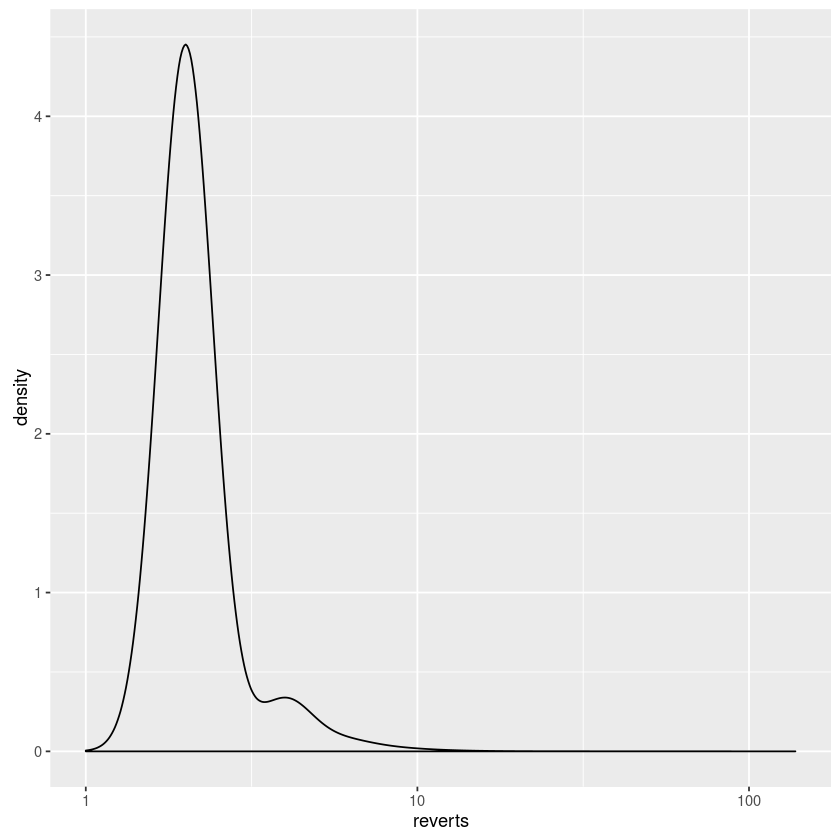

In [8]:
ggplot(page_reverts, aes(x=reverts)) + 
geom_density(adjust=10) + 
scale_x_log10()

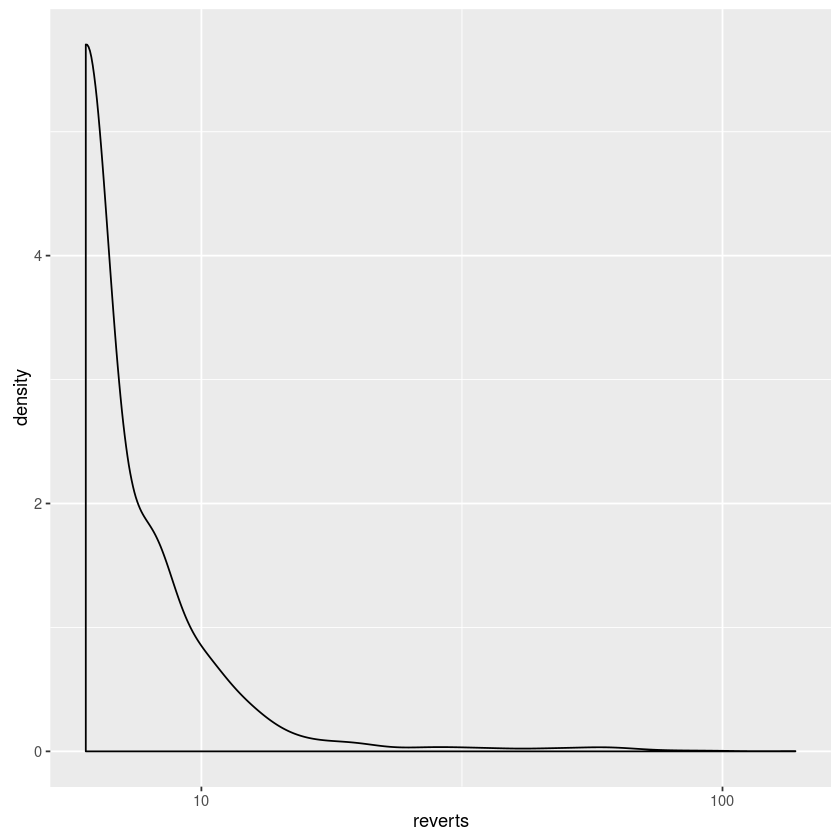

In [9]:
ggplot(page_reverts[reverts >= 5,], aes(x=reverts)) + 
geom_density(adjust=3) + 
scale_x_log10()

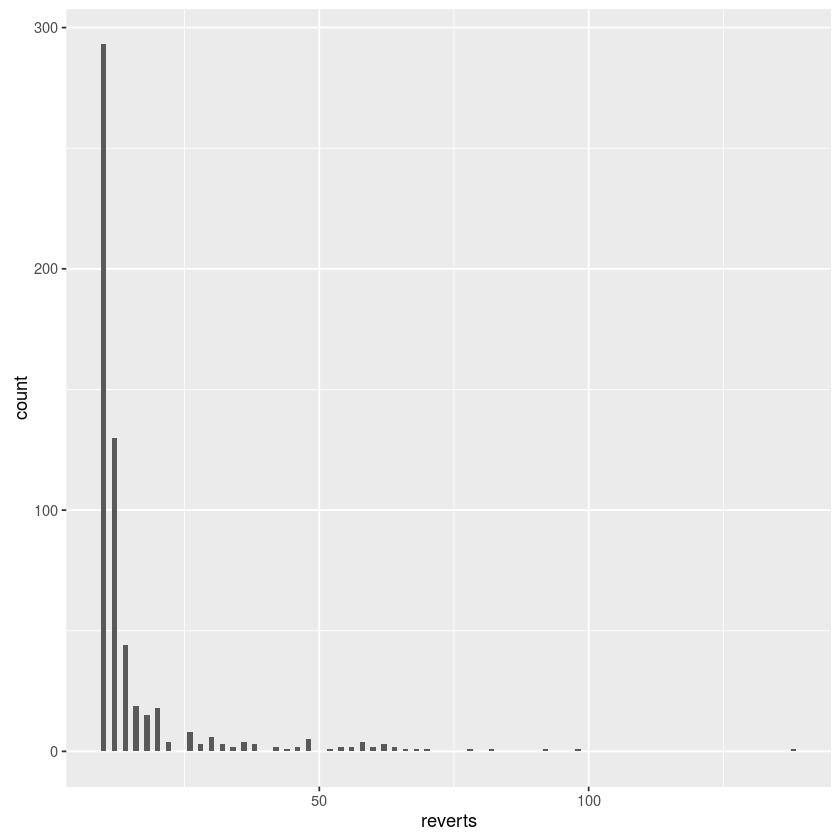

In [10]:
ggplot(page_reverts[reverts >= 10,], aes(x=reverts)) + 
geom_histogram(binwidth=1)

In [11]:
page_reverts[reverts >= 10,][1:10,]

rev_page,reverts,bots_involved,reverting_bots,reverted_bots,first_revert,last_revert
803,10,7,3,4,2008-08-03 16:20:59,2010-02-14 06:26:24
1688,30,21,10,11,2008-11-14 11:25:18,2010-11-14 04:03:47
1806,16,9,5,4,2010-09-25 02:16:26,2011-02-27 20:41:58
1984,10,9,5,4,2007-10-16 09:20:50,2010-12-31 10:21:58
3386,18,6,3,3,2011-05-31 10:22:14,2011-05-31 16:21:41
3457,48,15,7,8,2010-03-08 02:28:08,2011-03-01 06:55:19
5132,10,9,5,4,2010-08-30 04:14:24,2010-11-21 14:21:33
5487,82,4,2,2,2016-07-02 14:44:33,2016-07-07 19:02:07
5820,10,9,5,4,2010-09-22 04:36:34,2012-10-13 03:26:39
9239,10,8,4,4,2010-02-26 16:36:56,2012-06-10 08:01:23


In [12]:
page_bot_pairs = dt[
    page_namespace == 0,
    list(reverts=length(unique(rev_id)),
         first_revert=min(reverting_ts),
         last_revert=max(reverting_ts)),
    list(rev_page, bots=paste(pmin(as.character(reverting_user_text), as.character(rev_user_text)), 
                              pmax(as.character(reverting_user_text), as.character(rev_user_text))))]

png 
  2

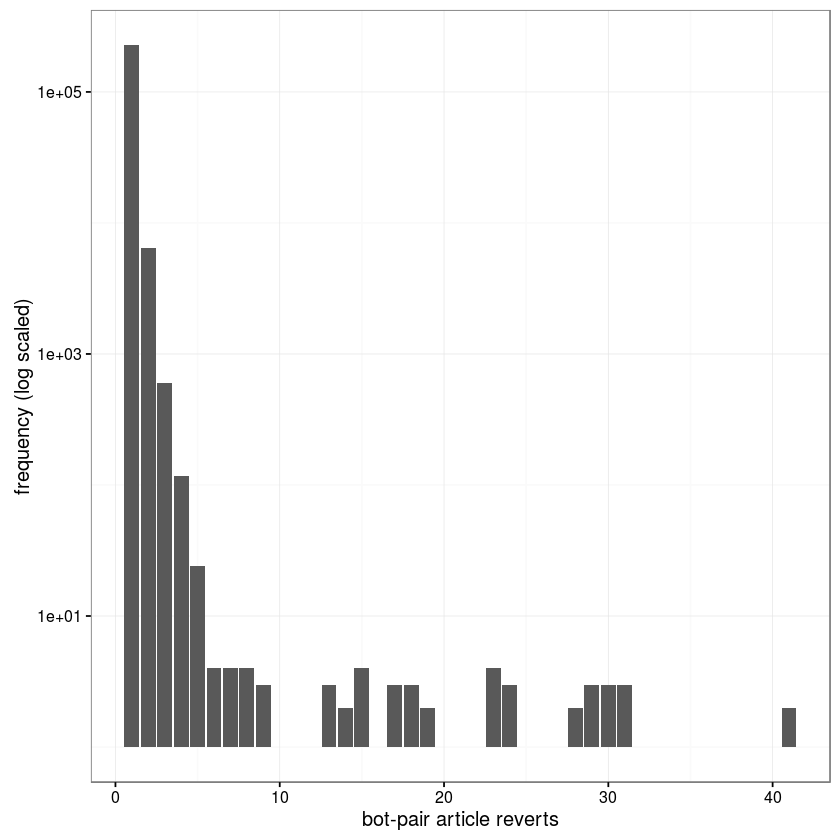

In [67]:
p = ggplot(page_bot_pairs, aes(x=reverts)) + 
theme_bw() + 
geom_bar() + 
scale_y_log10("frequency (log scaled)") + 
scale_x_continuous("bot-pair article reverts")
png("enwiki_bot_pair_article_reverts.png", height=1600, width=1600, res=400)
print(p)
dev.off()
print(p)

png 
  2

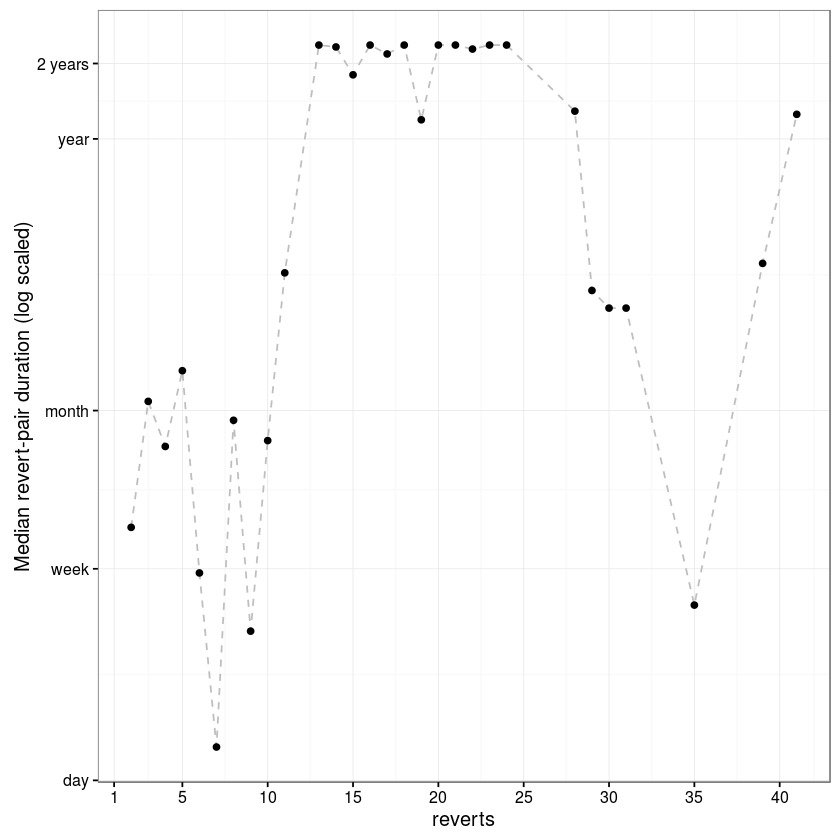

In [69]:
reverts_duration = page_bot_pairs[,
    list(
        duration.mean=mean(as.numeric(difftime(last_revert, first_revert, units="secs"))),
        duration.median=median(as.numeric(difftime(last_revert, first_revert, units="secs")))),
    list(reverts)]

p = ggplot(reverts_duration[reverts >= 2,], 
    aes(x=reverts, y=duration.median)) + 
theme_bw() + 
geom_line(color="gray", linetype=2) +
geom_point() +  
scale_y_log10("Median revert-pair duration (log scaled)",
              breaks=c(60*60*24, 60*60*24*7, 60*60*24*30, 60*60*24*365, 60*60*24*365*2),
              labels=c("day", "week", "month", "year", "2 years")) + 
scale_x_continuous(breaks=c(1, 5, 10, 15, 20, 25, 30, 35, 40))
png("enwiki_bot_revert_pair_duration.png", height=1600, width=1600, res=400)
print(p)
dev.off()
print(p)

In [7]:
page_bot_pairs[order(page_bot_pairs$reverts, decreasing=T),][1:10,]

rev_page,bots,reverts,first_revert,last_revert
5487,AnomieBOT Cyberbot II,41,2016-07-02 14:44:33,2016-07-07 19:02:07
5971841,FrescoBot Mathbot,41,2010-04-22 04:06:47,2012-10-17 21:36:17
49143051,ListeriaBot Yobot,39,2016-04-20 05:31:25,2016-08-14 08:25:09
4413025,AnomieBOT Cyberbot II,35,2016-07-02 20:13:11,2016-07-07 20:32:53
1121632,AnomieBOT Cyberbot II,31,2016-04-23 10:38:58,2016-07-07 08:36:16
8948190,AnomieBOT Cyberbot II,31,2016-04-23 10:38:48,2016-07-09 10:15:02
22807757,AnomieBOT Cyberbot II,31,2016-04-23 10:38:54,2016-07-09 10:15:03
5469430,AnomieBOT Cyberbot II,30,2016-04-23 10:38:53,2016-07-09 10:15:07
22881933,AnomieBOT Cyberbot II,30,2016-04-23 10:38:51,2016-07-09 10:15:06
30736081,AnomieBOT Cyberbot II,30,2016-04-23 10:39:04,2016-07-21 07:25:36


* Mathbot and FrescoBot are definitely fighting.
* AnomieBOT and Cyberbot II are definitely fighting.
* BG19bot and Yobot are fighting ListeriaBot.

This is a gold mine!  

-------------------------------------

The longest single-page mutual bot-on-bot revert sequence lasted 41 reverts and it continued over the course of 2 and a half years.  It happened on "List of Mathematicians (X)" between Mathbot and FrescoBot.  Mathbot updates the lists of mathematicians based on categorizations in Wikipedia. FrescoBot fixes link syntax.  When the target of the link and the label are the same, it simplifies the link.  Like clockwork, FrescoBot writes out a link of the structure [[<first name> <last name>|<last name>, <first name>]].  Normally these bots work together beautifully, but in the case of mathematicians with one name -- in this case "Xenocrates", Mathbot writes the link as [[Xenocrates|Xenocrates]] and FrescoBot dutifully, simplifies the link to just [[Xenocrates]].  Every time that Mathbot runs, it changes the link back to [[Xenocrates|Xenocrates]] and FrescoBot changes it back.  

-------------------------------------

Actually, it's a tie and honestly, this second case might be more interesting.  AnomieBOT and CyberBot II also had an 41 revert sequence on a single page, but it lasted for 41 reverts over the course of only 4 days!  On the article about "Foreign relations of the Central African Republic", AnomieBOT claimed to be "rescuing orphaned refs"  -- adding a reference to dead link by using the internet archive to provide a copy of the old referenced PDF titled "International Criminal Court: Background – Situation in the Central African Republic".  Every time that AnomieBOT "rescued" the link, Cyberbot II swing by and removed the reference with the confusing comment "Rescuing 1 sources".   This case is arguably worse than FrescoBot and Mathbot because it spanned many pages.  The bots had similar fights on the biography of the songwriter Rico Love (35 reverts), the broadcaster Dougie Vipond (31 reverts), and the song "Seasons Change" (31 reverts).  The list keeps going.  All told, these bots reverted each other 396 times on 15 pages -- constantly adding links to Internet Archive pages and then removing them again. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


n,pages
396,15


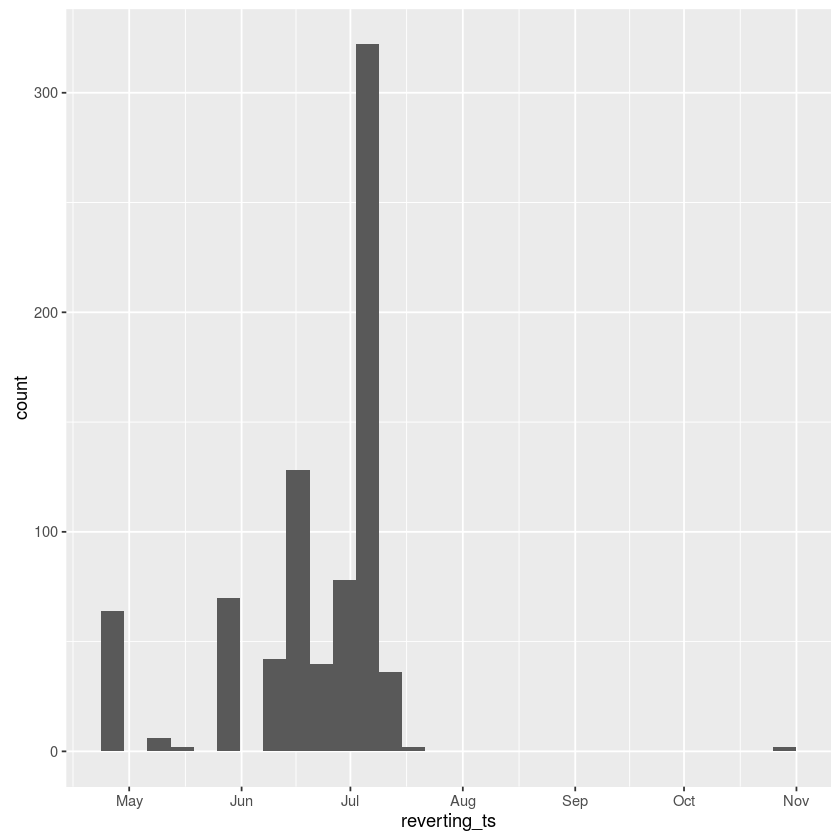

In [10]:
ggplot(dt[reverting_user_text %in% c("AnomieBOT", "Cyberbot II") &
          rev_user_text %in% c("AnomieBOT", "Cyberbot II"),], 
       aes(x=reverting_ts)) + 
geom_histogram(binwidth=1)

dt[reverting_user_text %in% c("AnomieBOT", "Cyberbot II") &
          rev_user_text %in% c("AnomieBOT", "Cyberbot II"),
    list(n=length(unique(rev_id)), pages=length(unique(rev_page)))]

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


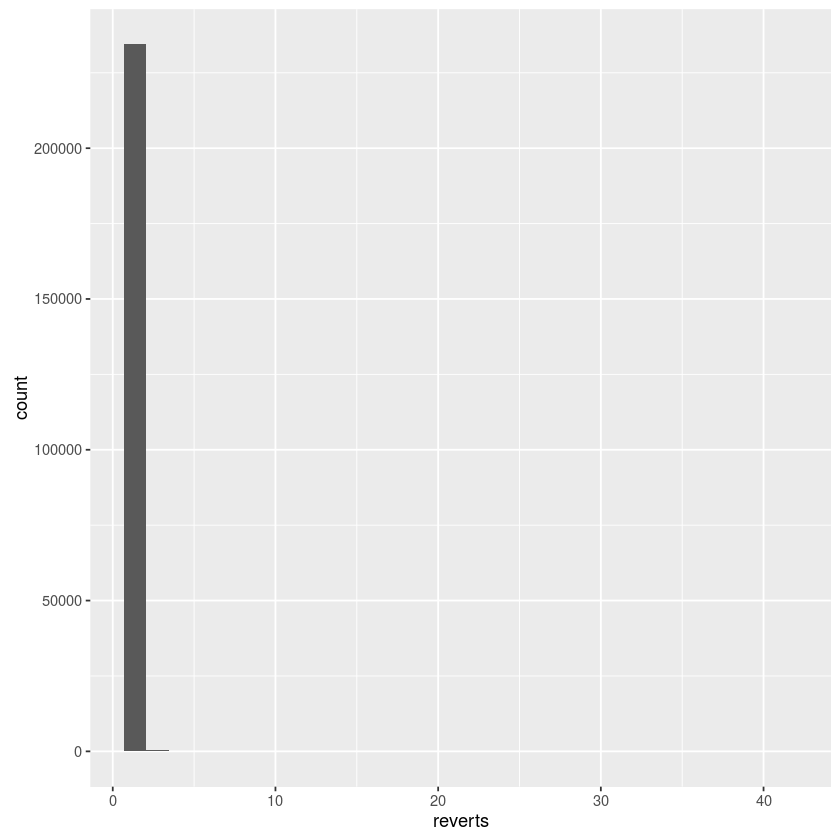

In [11]:
ggplot(page_bot_pairs, aes(x=reverts)) + 
geom_histogram(binwidth=1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


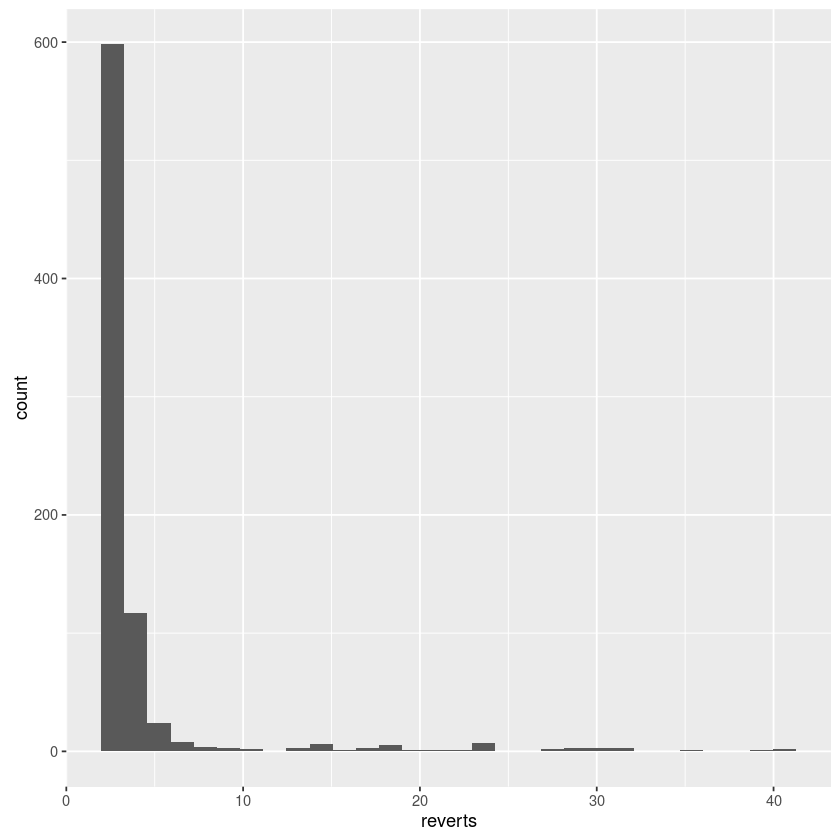

In [13]:
ggplot(page_bot_pairs[reverts > 2,], aes(x=reverts)) + 
geom_histogram(binwidth=1)

There's definitely some shape to this.  There's something around 20 reverts where, beyond that, there's some density.  Let's look at 3-10, 10-20, 20-30, and 30-40.  

In [14]:
page_bot_pairs[reverts > 2 & reverts < 10,][1:10,]

rev_page,bots,reverts,first_revert,last_revert
803,Synthebot TXiKiBoT,3,2008-08-26 21:44:51,2008-08-29 00:55:38
1806,WikitanvirBot Xqbot,5,2011-02-27 16:47:51,2011-02-27 20:41:58
3386,TjBot WikitanvirBot,7,2011-05-31 10:22:14,2011-05-31 16:21:41
3457,TjBot WikitanvirBot,9,2011-02-20 13:11:26,2011-03-01 06:55:19
3457,WikitanvirBot Xqbot,8,2011-02-21 00:33:06,2011-02-28 23:51:13
5935,GrouchoBot Xqbot,3,2011-07-02 21:05:01,2011-07-03 15:29:14
11145,Numbo3-bot Xqbot,4,2009-10-03 18:17:19,2009-10-13 07:05:51
11260,AnomieBOT Cyberbot II,6,2016-04-23 10:38:41,2016-06-09 08:01:56
18964,WikitanvirBot Xqbot,5,2011-02-18 18:12:16,2011-02-22 15:09:53
19673,Alexbot Obersachsebot,3,2009-12-12 17:33:53,2009-12-13 14:17:47


This is mostly fighting, but some of the fights are less obvious given so few interactions.

* TXiKiBoT and Synthebot aren't really fighting, but it's hard to figure why Synthebot was doing what it was doing. 
* EmausBot and KamikazeBot look like they might be fighting a little bit.  They are fighting over the same links that HRoestBot, Rubinbot, and SieBot are on the page titled "Alphons".
* Alexbot and RussBot are just managing redirects around naming of "Arab world", "Arab World", and "Arab Countries"
* WikitanvirBot Xqbot are fighting over whether or not to link to hiwiki.  Their fight lasts a few hours before it comes to an end.  This was due to a known bug and the workaround Xqt proposed is https://www.mediawiki.org/wiki/Special:Code/pywikipedia/9018

In [60]:
page_bot_pairs[reverts >= 10 & reverts < 20,][1:10,]

rev_page,bots,reverts,first_revert,last_revert
24260,WikitanvirBot Xqbot,11,2011-03-03 07:37:13,2011-06-17 19:49:41
55983,LaaknorBot WikitanvirBot,17,2011-05-31 22:49:13,2011-06-03 07:50:33
160108,ArthurBot Mjbmrbot,13,2010-11-08 09:20:36,2010-11-08 11:06:15
234906,28bot AnomieBOT,15,2012-12-19 08:58:37,2012-12-19 11:22:08
5971770,FrescoBot Mathbot,19,2010-06-05 21:26:08,2012-10-17 21:33:33
5971797,FrescoBot Mathbot,14,2010-07-05 21:26:18,2012-10-17 21:33:41
5971799,FrescoBot Mathbot,17,2010-06-05 21:26:26,2012-10-17 21:33:49
5971803,EmausBot Mathbot,10,2011-07-06 03:13:23,2011-07-28 21:35:04
5971806,FrescoBot Mathbot,13,2010-06-05 21:26:57,2012-10-17 21:34:20
5971809,FrescoBot Mathbot,15,2010-06-05 21:27:05,2012-09-16 16:11:51


* WikitanvirBot and Xqbot are doing what they were doing in the last set.  
* We already know about Frescobot and Mathbot.  The interaction with EmausBot is a fight too.  It seems that Mathbot is just overwriting the work of other bots that it encounters. 
* 28bot and AnomieBOT are fighting.  AnomieBOT adds a empty reference tag and 28bot reverts the edit because it sees the edit as a "test edit".  

OK, I'm satisfied.  Most single-page revert activity between bots that involves more than 2 edits is a fight.  Let's look at how many reverts are accounted for.  

In [61]:
length(unique(dt$rev_id))

[1] 500553

In [64]:
sum(page_bot_pairs[reverts > 2,]$reverts)

[1] 3509

lol.  So, maybe 0.7%.  
